# Data Cleaning

## Aims & Description of the Data

Data were scraped from the web into a **SQLite database** using the **Python scrapy** library. To do this, I chose the top 100 dressage horses, traced them back 2 generations, and gathered data for all descendants of the great-grandparents. The database has two tables: one stores show results, and the other stores pedigree information. The aim of the data cleaning process was to:
- Assess the quality of the scraped data (missingness, consistency, duplication)
- Put both tables in a [**tidy** format](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html)
- **Impute** missing values, where applicable 
- Summarise the show data per horse, rider, and horse-rider combination
- Give parents without rows their own rows in the pedigree table

In [151]:
library(RSQLite, quietly = T)
library(tidyverse, quietly = T)
library(lubridate, quietly = T)

conn <- dbConnect(RSQLite::SQLite(), "dressage.db")

ped <- dbGetQuery(conn, 'SELECT * FROM pedigree')
shows <- dbGetQuery(conn, 'SELECT * FROM show_results')

The pedigree table contains 1081 rows and 8 columns. Each row represents a horse, who is identified either by the column `horse_id` or the column `horse_ueln`. Some individuals will only be described in the sire/dam columns (`sire_id`, `sire_ueln`, `dam_id`, `dam_ueln`) - they should be given their own rows, with the parents set to NA. NA should be consistently used to represent missing values. The table also contains date of birth (`dob`) and sex (`sex`).

In [152]:
head(ped)
dim(ped)
str(ped)
summary(ped)

horse_id,dam_ueln,sire_ueln,dam_id,sire_id,dob,sex,horse_ueln
105AH62,276409090078202,276409090081903,NA,NA,23/04/2007,Female,276409090042107
102ZI90,276433330566801,276333332243993,NA,NA,07/07/2005,Female,276433330826405
103HX90,276431314606900,276333330471993,NA,NA,14/02/2006,Male,276431310648406
103CM31,276341410477388,276343430476299,NA,NA,12/02/2004,Female,276441411396304
DEN40739,276331310958893,276309090304085,NA,NA,24/04/2003,Male,208333200301452
105BZ34,276373732023391,276341410479692,NA,NA,17/05/2009,Female,276431310562909


[1] 1081    8

'data.frame':	1081 obs. of  8 variables:
 $ horse_id  : chr  "105AH62" "102ZI90" "103HX90" "103CM31" ...
 $ dam_ueln  : chr  "276409090078202" "276433330566801" "276431314606900" "276341410477388" ...
 $ sire_ueln : chr  "276409090081903" "276333332243993" "276333330471993" "276343430476299" ...
 $ dam_id    : chr  NA NA NA NA ...
 $ sire_id   : chr  NA NA NA NA ...
 $ dob       : chr  "23/04/2007" "07/07/2005" "14/02/2006" "12/02/2004" ...
 $ sex       : chr  "Female" "Female" "Male" "Female" ...
 $ horse_ueln: chr  "276409090042107" "276433330826405" "276431310648406" "276441411396304" ...


   horse_id           dam_ueln          sire_ueln            dam_id         
 Length:1081        Length:1081        Length:1081        Length:1081       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
   sire_id              dob                sex             horse_ueln       
 Length:1081        Length:1081        Length:1081        Length:1081       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

The shows table has 18033 rows and 9 columns. Each row represents a single show results for a single horse/rider combination. In this table, horses are described only by `horse_id`. Riders are identified by their own unique `rider_id`. This table also includes `dob` and `sex` as in the pedigree table; the country code of the country where the show took place (`location`); the level of event (`event_type`); the event name (`comp_title`); the position of the combination (`position`) and their score (`score`). 

In [153]:
head(shows)
dim(shows)
str(shows)
summary(shows)

location,event_type,comp_title,horse_id,dob,sex,rider_id,position,score
NED,CDI-W,GP FS - Grand Prix Freestyle to Music,102ZI90,15 - 07/07/2005,Mare,10011389,1,90.280
NED,CDI-W,GP - Grand Prix,102ZI90,15 - 07/07/2005,Mare,10011389,1,83.565
SWE,CDI5*,GP FS - Grand Prix Freestyle to Music,102ZI90,15 - 07/07/2005,Mare,10011389,2,89.310
SWE,CDI5*,GP - Grand Prix,102ZI90,15 - 07/07/2005,Mare,10011389,1,83.652
GER,CDI-W,GP FS - Grand Prix Freestyle to Music,102ZI90,15 - 07/07/2005,Mare,10011389,2,87.240
GER,CDI-W,GP - Grand Prix,102ZI90,15 - 07/07/2005,Mare,10011389,1,81.565


[1] 18033     9

'data.frame':	18033 obs. of  9 variables:
 $ location  : chr  "NED" "NED" "SWE" "SWE" ...
 $ event_type: chr  "CDI-W" "CDI-W" "CDI5*" "CDI5*" ...
 $ comp_title: chr  "GP FS - Grand Prix Freestyle to Music" "GP - Grand Prix" "GP FS - Grand Prix Freestyle to Music" "GP - Grand Prix" ...
 $ horse_id  : chr  "102ZI90" "102ZI90" "102ZI90" "102ZI90" ...
 $ dob       : chr  "15 - 07/07/2005" "15 - 07/07/2005" "15 - 07/07/2005" "15 - 07/07/2005" ...
 $ sex       : chr  "Mare" "Mare" "Mare" "Mare" ...
 $ rider_id  : chr  "10011389" "10011389" "10011389" "10011389" ...
 $ position  : chr  "1" "1" "2" "1" ...
 $ score     : chr  "90.280" "83.565" "89.310" "83.652" ...


   location          event_type         comp_title          horse_id        
 Length:18033       Length:18033       Length:18033       Length:18033      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
     dob                sex              rider_id           position        
 Length:18033       Length:18033       Length:18033       Length:18033      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
    score          
 Length:18033      
 Class :character  
 Mode  :character  

## Cleaning the Pedigree Table 

Duplication is very likely due to the scraping method: individuals who are descended from more than one of the great-grandparents I used as starting points will have been captured multiple times. I exclude 76 rows that are exact duplicates of another row in the table. Some horses have a second ID in brackets after the first, but this id is not used to refer to them in the shows table or as parents, so I remove it. 

In [154]:
ped <- as_tibble(ped)

# replace blank cells with NA
ped[ped == ''] <- NA
# remove duplicate rows 
ped <- ped %>%
    mutate_all(str_trim) %>%
    distinct()

dim(ped)

# remove unnecessary identifier
ped$horse_id <- str_trim(str_remove(ped$horse_id, "\\(.*"))

[1] 1005    8

Next, I standardise the sexes. Although the distinction between geldings and stallions may be informative, 140 males are not distinguished as stallion or gelding. Thus, I am forced to collapse all males into a single category (1). This results in the removal of another 2 rows from the pedigree table, which likely were individuals listed as both male or female and also as either gelding, stallion, or mare. 

In [155]:
table(ped$sex)

ped <- ped %>%
    mutate(sex = case_when(sex == "Mare" ~ 0,
                           sex == "Female" ~ 0,
                           sex == "Gelding" ~ 1,
                           sex == "Stallion" ~ 1,
                           sex == "Male" ~ 1))

table(ped$sex)
ped$sex <- as.character(ped$sex)

ped <- distinct(ped)
dim(ped)


  Female  Gelding     Male     Mare Stallion 
      13      351      140      267      210 


  0   1 
280 701 

[1] 1005    8

Next, I want to obtain year of birth (YYYY) from the `dob` column. This column contains data in one of three formats: YYYY, DD/MM/YYYY or DD/MM/YYYY (age). Those in YYYY format fail to parse with `lubridate`, but I fix this with `case_when()`. 

In [156]:
ped$dob <- str_trim(str_remove(ped$dob, "\\(.*"))
ped$yob <- year(dmy(ped$dob))
ped$yob <- as.character(ped$yob)

ped <- ped %>%
    mutate(yob = case_when(!is.na(yob) ~ yob,
                           is.na(yob) & !is.na(dob) ~ dob,
                           is.na(yob) & is.na(dob) ~ NA_character_))

ped$dob <- NULL

Warning message:
" 54 failed to parse."

Despite the fact that I have removed identical rows, some IDs and UELNs still appear twice (35 and 41, respectively). The use of multiple identifier systems within the one dataset is the most difficult challenge I encountered when cleaning this data. The eventual goal is to represent individuals with just a single identifier in all instances. I suspect that this may be due to the fact that there were two different pedigree pages for some horses on the website from which the data was scraped, and one page might have had richer data than the other. Thus, I merge rows sharing IDs where they differ only by missing data. Rows that differ in the content of non-NA cells are left as is. 

In [157]:
sum(table(ped$horse_id) > 1)
sum(table(ped$horse_ueln) > 1)

ped <- ped %>% 
     group_by(horse_ueln, horse_id) %>% 
     summarise(across(.fns = ~{x <- unique(na.omit(.));x[1:max(1, length(x))]}))
dim(ped)

[1] 41

[1] 35

`summarise()` regrouping output by 'horse_ueln', 'horse_id' (override with `.groups` argument)


[1] 987   8

This leaves 24 duplicated IDs and 19 duplicated UELNs. I want to know what fields are different between rows with a shared identifier. 

In [158]:
sum(table(ped$horse_id) > 1)
sum(table(ped$horse_ueln) > 1)

getDupIds <- function(df, id_type) {
    idlist <- df %>% 
        count(!!sym(id_type)) %>%
        filter(n > 1) %>%
        pull(id_type)
    
    idlist <- idlist[!is.na(idlist)]
    
    if (length(idlist) != 0) {
        return(idlist) 
    } else {
        return("No duplicate IDs.")
    }
 }

countRowDiffs <- function(dup_id, df, id_type) {
    df[is.na(df)] <- "None"
    rows <- df[df[[id_type]] == dup_id,]
    
    comparisons <- combn(nrow(rows), 2)
    
    for (col in 1:ncol(comparisons)) {
        if (col == 1) {
            output <- rows[comparisons[1,col],] != rows[comparisons[2,col],]
        } else {
            output <- output + (rows[comparisons[1,col],] != rows[comparisons[2,col],])
        }
    }
    
    return(output)
}

colSums(do.call(rbind.data.frame, (map(getDupIds(ped, "horse_id"), countRowDiffs, ped, "horse_id"))))
colSums(do.call(rbind.data.frame, (map(getDupIds(ped, "horse_ueln"), countRowDiffs, ped, "horse_ueln"))))

[1] 24

[1] 19

horse_ueln   horse_id   dam_ueln  sire_ueln     dam_id    sire_id        sex 
         4          0         21          0          0          0          0 
       yob 
         0

horse_ueln   horse_id   dam_ueln  sire_ueln     dam_id    sire_id        sex 
         0          0         19          0          0          0          0 
       yob 
         0

There appears to be discrepancies between rows sharing identifiers in the `dam_ueln` and `horse_ueln` columns. I speculate that "sires of dams" might have become incorporated into this column, so I investigate whether the duplicated dam UELNs are ever present in `horse_ueln`, and listed as male, or present in `sire_ueln`. However, all the inconsistent dams with sex are female, and only two of forty are in the sire column. Ultimately, I conclude that the quality of the dam data is poor, and decide to perform analysis on sires alone.

In [159]:
dupids <- getDupIds(ped, "horse_id")
dupuelns <- getDupIds(ped, "horse_ueln")

dupdams <- ped %>%
    filter(horse_id %in% dupids | horse_ueln %in% dupuelns) %>%
    pull(dam_ueln)

length(dupdams)
sum(dupdams %in% ped$horse_ueln)
sum(dupdams %in% ped$sire_ueln)

ped %>%
    filter(horse_ueln %in% dupdams & !is.na(horse_ueln)) %>%
    pull(sex)

ped$dam_id <- NULL
ped$dam_ueln <- NULL

ped <- distinct(ped)

getDupIds(ped, 'horse_id')
getDupIds(ped, 'horse_ueln')

[1] 40

[1] 19

[1] 2

[1] "0" "0" "0" "0" "0" "0" "0" "0" "0" NA  NA  "0" "0" "0" "0" "0" "0"

[1] "No duplicate IDs."

[1] "No duplicate IDs."

Next I want to give each sire that does not have one his own row. First I check that all sires that already have their own row have the correct sex. Indeed, all sires are listed as males. This, with the consistency of sire data across duplicated records, assures me that sires have a higher level of data quality than what I observed for the dams.

In [160]:
sireids <- unique(ped$sire_id)
sireuelns <- unique(ped$sire_ueln)

sires <- ped %>%
    filter((horse_id %in% sireids | horse_ueln %in% sireuelns) & !is.na(horse_ueln))

pull(sires, sex)

[1] "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1"
[20] "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1"
[39] "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1"
[58] "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1"
[77] "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1"
[96] "1" "1" "1"

Now the pedigree table is mostly clean, but before I finish I will examine missingness in the dataset. As is demonstrated by the UpSet plot below, `sire_id` is missing most of the time. This is because sires are most commonly referred to by their UELNs. Not all individuals will have a sire listed, because pedigree often didn't not stretch back very far. `sex` and `yob` are not commonly missing. `horse_ueln` has some missingness, meaning that we will not be able to identify if they are also sires. Reassuringly, all horses have a unique ID. 

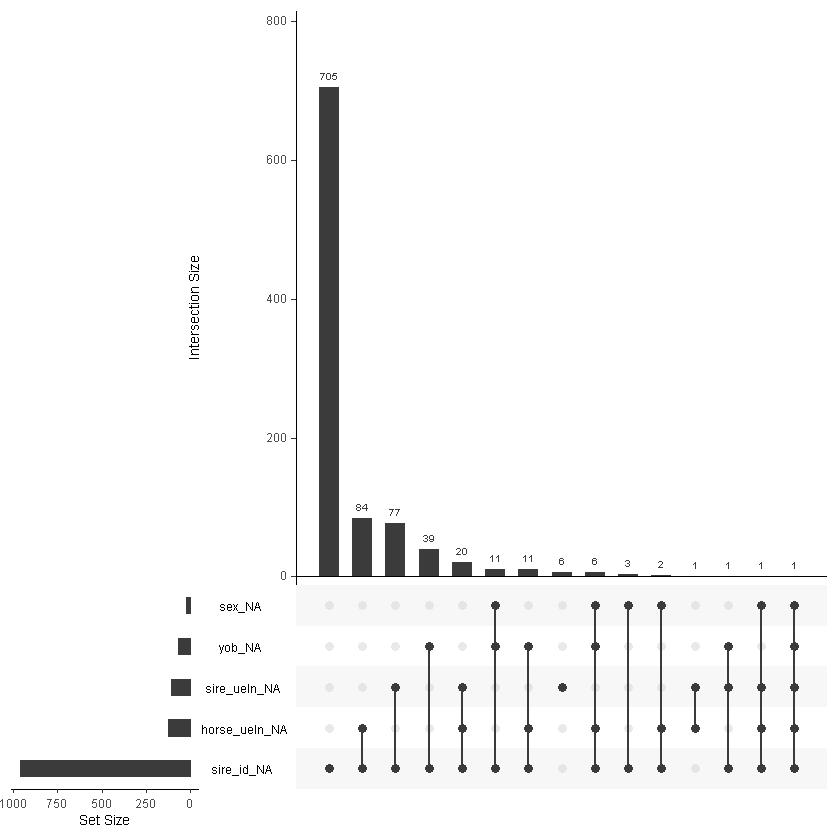

In [161]:
library(naniar)

gg_miss_upset(ped)

## Cleaning the Shows Table

To begin, I clean the `yob` and `sex` columns as I did for `ped`. I also double check that the `ped` and `shows` tables agree about the sex and year of birth of individual horses. This gives me confidence in the accuracy of my data, given that the sex and year of birth for both tables were scraped from different webpages.

In [162]:
shows <- shows %>%
  mutate(sex=replace(sex, sex == "Mare", "0")) %>%
  mutate(sex=replace(sex, sex == "Stallion", "1")) %>%
  mutate(sex=replace(sex, sex == "Gelding", "1")) %>%
  mutate(sex=replace(sex, sex == "Male", "1")) %>%
  mutate(sex=replace(sex, sex == "Female", "0"))

shows$dob <- str_trim(str_remove(shows$dob, "^[^-]*-"))

shows$yob <- year(dmy(shows$dob))

table(shows$sex)
head(shows$yob)

ped %>%
  inner_join(., shows, by = "horse_id") %>%
  select(horse_id, sex.y, sex.x, yob.x, yob.y) %>%
  distinct() %>%
  count(horse_id) %>%
  filter(n > 1)


    0     1 
 3059 14974 

[1] 2005 2005 2005 2005 2005 2005

Adding missing grouping variables: `horse_ueln`


horse_ueln,horse_id,n


I assign each show a unique identifier. Seven of the individuals with show results in this table are not included in the pedigree table, and are thus discarded. I also remove team show results, as these are the sum of all individuals in the team.

In [163]:
shows$show_id <- c(1:nrow(shows))
shows$score <- as.numeric(shows$score)

shows <- shows %>% 
  filter(horse_id %in% ped$horse_id)

shows %>%
 group_by(comp_title) %>%
 summarise(mean = mean(score, na.rm = T)) %>%
 filter(mean > 100)
  
shows <- shows %>%
  filter(!str_detect(comp_title, "Team"))

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"`summarise()` ungrouping output (override with `.groups` argument)


comp_title,mean
Team Classification,142.4083


A histogram is used to identify any other outliers. There is a peak between 0 and 20, which is highly unusual. These points are exclusively from young horse (YH) shows, which have different scoring systems. All young horse shows are removed from the dataset, leaving an approximately normal distribution of show scores, with the except of one outlier with a score of 0. This score is impossible, so I exclude this individual. The dataset now contains 16,352 show records, 548 of which are NA.

`summarise()` ungrouping output (override with `.groups` argument)


comp_title,mean
Small Final - YH 6 YO,7.600000
YH 5 Final,16.280000
YH 5 Final - Test for 5-y,9.220000
YH 5 Prel,15.421538
YH 5 Prel - Preliminary T,8.680000
YH 6 Final,27.106667
YH 6 Final - Test for 6-y,8.293333
YH 6 Prel,21.868000
YH 6 Prel - Preliminary T,8.311667


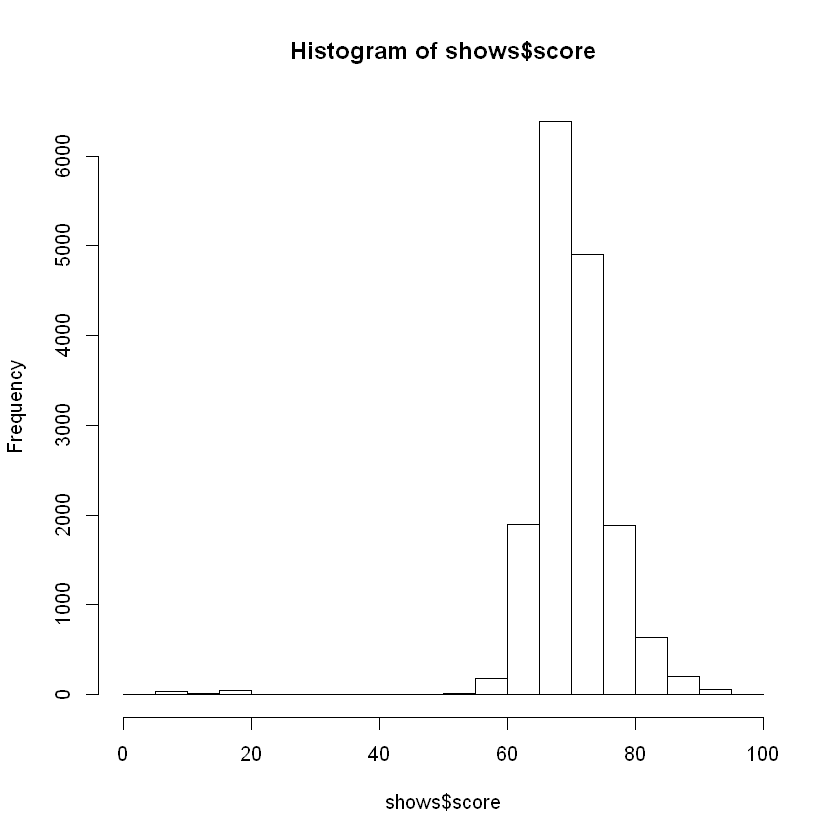

In [164]:
hist(shows$score)

shows %>%
  group_by(comp_title) %>%
  summarise(mean = mean(score, na.rm = T)) %>%
  filter(mean < 30)

shows <- shows %>% 
  filter(!str_detect(comp_title, "YH")) %>%
  filter(score != 0 | is.na(score))

I hypothesise that these NAs may represent individuals who did not complete competition, due to retirement, for example. There are four categories for non-completion in this dataset: EL (elimination), DSQ (disqualification), RET (retirement), and WD (withdrawn). There are 94, 7, 124, and 148 occurances of these, respectively, within the data. The scores are always NA when one of these labels is present. Scores for these individuals will be imputed in the exploratory analysis. 

This leaves 218 unaccounted for NA scores. They are enriched for "final classifications" and "historical rules" which would be an overall position, rather than a single show's score. I remove these also. 

In [165]:
unique(shows$position)
shows %>%
  filter(position == "RET" | position == "DSQ" | position == "WD" | position == "EL") %>%
  count(position)

shows %>%
  filter(!(position == "RET" | position == "DSQ" | position == "WD" | position == "EL")) %>%
  filter(is.na(score)) %>%
  count(comp_title)

shows <- shows %>% 
  filter(!str_detect(comp_title, "Final Classification") & !str_detect(comp_title, "Historical Rule"))

[1] "1"   "2"   "4"   "3"   "31"  "WD"  "6"   "7"   "5"   "9"   "16"  "EL" 
[13] "8"   "13"  "12"  "10"  "19"  "11"  "18"  "RET" "21"  "17"  "24"  "25" 
[25] "29"  "14"  "15"  "26"  "20"  "27"  "28"  "38"  "23"  "22"  "33"  "30" 
[37] "35"  "32"  "55"  "58"  "37"  "65"  "41"  "45"  "DSQ" "34"  NA    "36" 
[49] "50"  "63"  "73"  "74"  "56"  "60"  "39"  "51"  "70"  "43"  "61"  "76" 
[61] "40"  "47"  "42"  "54"  "44"  "64"  "57"  "59"  "53"  "66"  "84"  "71" 
[73] "62"  "93"

position,n
DSQ,7
EL,94
RET,125
WD,148


comp_title,n
FC - Final Classification,28
Final Classification,91
Hist - Historical Rule,3
J FS - Junior Freestyle to Music,1
Y FS - Young Riders Freestyle to Music,1


This left only 2 shows with NA scores that could not be explained by non-completion or competition type. This is just 0.012% of all of the scraped shows, so shouldn't exert a strong effect on the data. I looked to see whether certain riders or horses were enriched for these unexplained NA scores. Indeed, both records came from the same combination, but this combination also has 25 other unaffected rows. I decide to just eliminate these two show results, although I cannot explain why they are missing.

In [166]:
sum(is.na(shows$score))

shows %>%
  filter(!(position == "RET" | position == "DSQ" | position == "WD" | position == "EL")) %>%
  filter(is.na(score)) 

nrow(shows[shows$horse_id == "GER43431",])

shows <- shows %>%
  filter(!(!(position == "RET" | position == "DSQ" | position == "WD" | position == "EL") & is.na(score)))

[1] 425

location,event_type,comp_title,horse_id,dob,sex,rider_id,position,score,yob,show_id
GER,CH-EU-Y-D,Y FS - Young Riders Freestyle to Music,GER43431,12/07/2001,1,10019451,2,NA,2001,12972
NED,CH-EU-J-D,J FS - Junior Freestyle to Music,GER43431,12/07/2001,1,10019451,1,NA,2001,12974


[1] 27

Finally, I am going to impute score values for the non-completion categories. I retain position, as number of non-completions could be an interesting feature. However, I believe that failing to complete a show due to elimination or disqualification should inevitably be detrimental to a combination's measure of success as they indicate that the combination performed poorly in that show. Retirement and withdrawal are slightly less clear, because they may not necessarily represent poor performance. For example, a rider may choose to retire when they realise they cannot beat the current leading score, but that doesn't necessarily mean their performance was bad, just not good enough to take home a trophy. Withdrawal may occur due to some irrelevant circumstances, such as illness or travel issues. 

Thus, I propose two crude imputations of these categories. 260 shows marked WD or RET will be assigned a score randomly drawn from a normal distribution (68.81511, 3.269806). The score shows are approximately normally distributed, so this distribution seems appropriate. I have overlayed this distribution (green) over the true distribution (black) in the graph below. Essentially, we are assuming that withdrawal or retirement means that a combination is less likely than normal to have achieved an especially high score, but on the whole their scores are similar to that of other shows. I choose to sample shows from a distribution rather than assign a single value, because I do not want to compromise the variance or normality of my data. 

Note that due to the random nature of the imputation generation, values may vary slightly in the html output. I immediately export all imputed data into new tables in `dressage.db`. 

Warning message:
"Removed 373 rows containing non-finite values (stat_density)."

location,event_type,comp_title,horse_id,dob,sex,rider_id,position,score,yob,show_id
GER,CDI4*,GPS - Grand Prix Special,103HX90,14/02/2006,1,10023552,WD,71.18227,2006,98
NED,CDI-W,GP FS - Grand Prix Freestyle to Music,GER45558,21/04/2002,1,10012844,RET,74.15765,2002,294
FRA,CDI3*,Grand Prix Special,104HK07,15/05/2006,0,10029550,RET,66.78297,2006,1071
NED,CDIO5*-NC,Grand Prix,104HK07,15/05/2006,0,10029550,WD,71.11050,2006,1073
NED,CDIY,Y Ind - Young Riders Individual Competit...,105FU85,17/05/2008,1,10066419,RET,71.34623,2008,1242
ESP,CDI4*,GPS - Grand Prix Special,103DW31,01/01/2005,1,10040382,WD,73.18840,2005,1362
ESP,CDI3*,GP - Grand Prix,103DW31,01/01/2005,1,10040382,WD,68.51519,2005,1368
NED,CDI3*,GP - Grand Prix,103VM89,03/04/2004,1,10034410,RET,75.89667,2004,1418
NED,CDI3*,GP - Grand Prix,103VM89,03/04/2004,1,10034410,RET,69.01703,2004,1433
NED,CDI3*,GP - Grand Prix,103VM89,03/04/2004,1,10034410,RET,64.79355,2004,1437


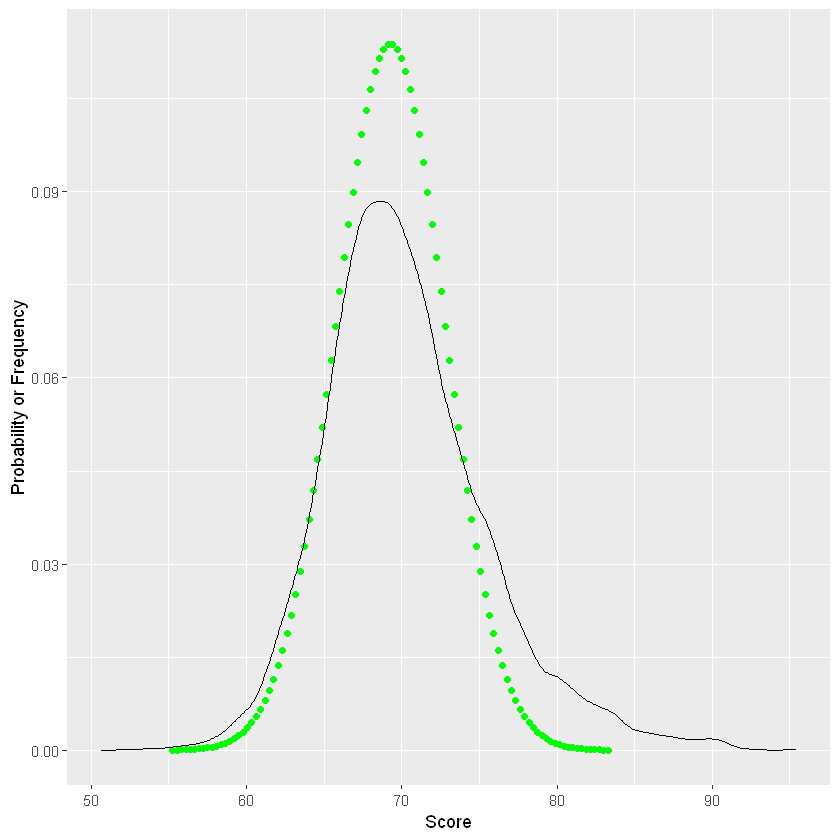

In [167]:
wd_ret_mean <- mean(shows$score, na.rm = T) - 1
wd_ret_sd <- sd(shows$score, na.rm = T)/1.5

wd_ret_points <- seq(-4, 4, length = 100) * wd_ret_sd + wd_ret_mean
wd_ret_dist <- dnorm(wd_ret_points, wd_ret_mean, wd_ret_sd)

ggplot() +
  geom_point(aes(x = wd_ret_points, y = wd_ret_dist), color = "green") + 
  geom_freqpoly(data = shows, aes(x = score), stat = "density") + 
  xlab("Score") +
  ylab("Probability or Frequency")

wt_ret_imputed <- rnorm(nrow(shows[shows$position %in% c('WD', 'RET'),]), wd_ret_mean, wd_ret_sd)

shows[shows$position %in% c("WD", "RET"),]$score <- wt_ret_imputed

shows %>% 
  filter(position %in% c("WD", "RET"))

On the other hand, I want to penalise individuals who are eliminated (EL) or disqualified (DSQ). Thus, I impute values from a normal distribution (66.56, 4.904709). The mean of this distribution is the 25th percentile of the data. Thus, I am penalising combinations for having been eliminated or disqualified. 

25% 
66.8

Warning message:
"Removed 101 rows containing non-finite values (stat_density)."

[1] 0

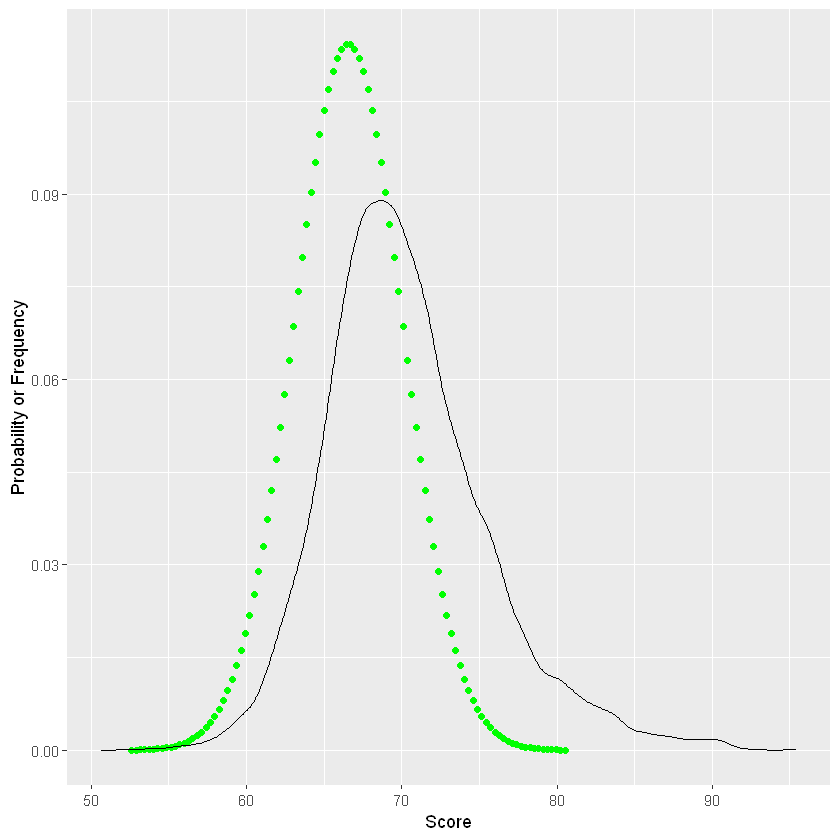

In [168]:
quantile(shows$score, probs = 0.25, na.rm = T)
el_dsq_mean <- 66.565
el_dsq_sd <- sd(shows$score, na.rm = T)/1.5

el_dsq_points <- seq(-4, 4, length = 100) * el_dsq_sd + el_dsq_mean
el_dsq_dist <- dnorm(el_dsq_points, el_dsq_mean, el_dsq_sd)

ggplot() +
  geom_point(aes(x = el_dsq_points, y = el_dsq_dist), color = "green") + 
  geom_freqpoly(data = shows, aes(x = score), stat = "density") + 
  xlab("Score") +
  ylab("Probability or Frequency")

el_dsq_imputed <- rnorm(nrow(shows[shows$position %in% c("DSQ", "EL"),]), el_dsq_mean, el_dsq_sd)

sum(is.na(shows$position))

In [169]:
dbWriteTable(conn, "clean_pedigree", ped, overwrite = T)
dbWriteTable(conn, "clean_shows", shows, overwrite = F)

dbDisconnect(conn)

ERROR: Error: Table clean_shows exists in database, and both overwrite and append are FALSE


## Reflection

I gained a lot of skills from this project. This was my **first time using web scraping** to generate my own data. In hindsight, there are several things I would have done differently. I would have spent more time assessing the quality of the data generated before deploying the spider to collect the whole dataset. I also would have acquired more data - for example, dates and times for each individual show. I believe that this would have allowed me to do some modelling down the line, that the current data were not really suitable for. 

This is also increased my experience in data cleaning, particularly in dealing with a strange ID system!